# Load data and pre-process data

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

The bearing dataset was downloaded from the NASA Prognostics Data Repository (https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#bearing)

There are 3 datasets in total and each dataset consists of individual files that are 1-second vibration signal snapshots recorded at specific intervals. We use the second one to perform this study. 

In [2]:
data_dir = '2nd_test'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    # each file consists of 20480 rows of data with the sampling rate set at 20 kHz
    # data in each two adjacent files are measured 10 minutes away from each other
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    # for the purpose of the anomaly detection study, we only keep the mean of the 20480 data points in each file
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1, 4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)

merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']
merged_data.index = pd.to_datetime(
    merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()

print('data shape:', merged_data.shape)

merged_data.head()

data shape: (984, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


It looks like Bearing 1 started to have some abnormal trend after 2004-02-16 while others still performed quite normal until after 2004-02-18. In traditional SPC, if we are unlucky, we may not have selected Bearing 1 to be monitored and may not have detected any issue before 2004-02-19, when a breakdown event occurred.

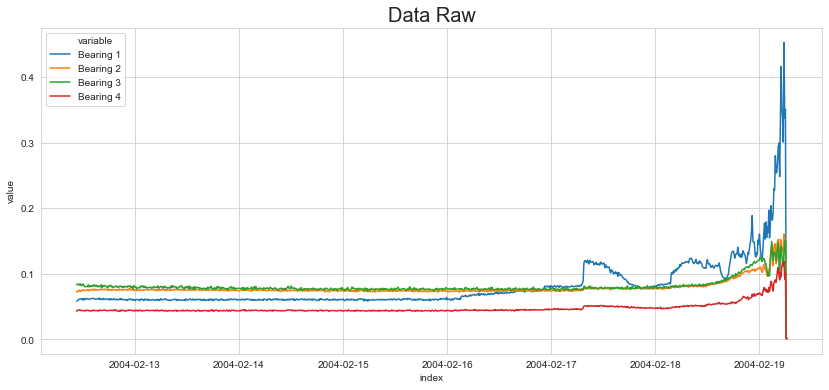

In [6]:
dataset_melt_merged_data = pd.melt(merged_data.reset_index(), id_vars='index')

plt.figure(figsize=(14, 6))
sns_plot = sns.lineplot(x='index', y='value', hue='variable',
                        data=dataset_melt_merged_data).set_title('Data Raw', fontsize=20)
plt.show()

In [7]:
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]

print('data train shape:', dataset_train.shape)
print('data test shape:', dataset_test.shape)

data train shape: (222, 4)
data test shape: (760, 4)


In [4]:
# Normalise the data

scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train),
                       columns=dataset_train.columns,
                       index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test),
                      columns=dataset_test.columns,
                      index=dataset_test.index)

# Approach 1: Multivariate statistical analysis (unsupervised)

In [5]:
'''
Define some helper functions
'''

# covariance matrix calculation


def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

# Mahalanobis distance calculation


def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

# outlier detection


def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

# threshold value calculation for classifying datapoint as anomaly


def MD_threshold(dist, std_dev=4, verbose=False):
    threshold = np.mean(dist) + np.std(dist) * std_dev
    return threshold

# Check if matrix is positive definite


def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

## Dimensionality reduction using principal component analysis: PCA

PCA performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximised. In practice, the covariance matrix of the data is constructed and the eigenvectors of this matrix are computed. The eigenvectors that correspond to the largest eigenvalues (the principal components) can now be used to reconstruct a large fraction of the variance of the original data. The original feature space has now been reduced (with some data loss, but hopefully retaining the most important variance) to the space spanned by a few eigenvectors.

In [6]:
from sklearn.decomposition import PCA

In [7]:
# only keep the first 2 principal components
pca = PCA(n_components=2, svd_solver='full')

X_train_PCA = pca.fit_transform(X_train)
print(pca.explained_variance_)

[0.06830952 0.02739669]


In [8]:
# X_train_PCA shape: (num_training_examples x num_principal_components)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
# X_test_PCA shape: (num_test_examples x num_principal_components)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

# principal_components_train shape: (num_training_examples x num_principal_components)
principal_components_train = np.array(X_train_PCA.values)
# principal_components_test shape: (num_test_examples x num_principal_components)
principal_components_test = np.array(X_test_PCA.values)

## Multivariate anomaly detection with Mahalanobis distance

Consider the problem of estimating the probability that a data point belongs to a distribution, as described above. Our first step would be to find the centroid or center of mass of the sample points. Intuitively, the closer the point in question is to this center of mass, the more likely it is to belong to the set. However, we also need to know if the set is spread out over a large range or a small range, so that we can decide whether a given distance from the center is noteworthy or not. The simplistic approach is to estimate the `standard deviation` of the distances of the sample points from the center of mass. By plugging this into the normal distribution we can derive the probability of the data point belonging to the same distribution.

The drawback of the above approach was that we assumed that the sample points are distributed about the center of mass in a spherical manner. Were the distribution to be decidedly non-spherical, for instance `ellipsoidal`, then we would expect the probability of the test point belonging to the set to depend not only on the distance from the center of mass, but also on the direction. In those directions where the ellipsoid has a short axis the test point must be closer, while in those where the axis is long the test point can be further away from the center. Putting this on a mathematical basis, the ellipsoid that best represents the set’s probability distribution can be estimated by calculating the covariance matrix of the samples. The `Mahalanobis distance (MD)` is the distance of the test point from the center of mass divided by the width of the ellipsoid in the direction of the test point.

(https://www.machinelearningplus.com/statistics/mahalanobis-distance/)

`Mahalonobis distance` is the distance between a point and a distribution. And not between two distinct points. It is effectively a multivariate equivalent of the Euclidean distance.
* It transforms the columns into uncorrelated variables
* Scale the columns to make their variance equal to 1
* Finally, it calculates the Euclidean distance

The formula to compute `Mahalonobis distance` is:

$$
D^2 = (x - m)^T \cdot C^{-1} \cdot (x - m)
$$

where

* $D^2$ is the square of the Mahalonobis distance
* $x$ is the vector of the observation (row in a dataset)
* $m$ is the vector of mean values of indepedent variables (mean of each column)
* $C^{-1}$ is the inverse covariance matrix of independent variables
* $(x - m)$ is essentially the distance of the vector from the mean
* $(x - m)^T \cdot C^{-1}$ is essentially a multivariate equivalent of the regular standardisation $z = \frac{x - \mu}{\sigma} = \frac{(\text{x vector}) - (\text{mean vector})}{\text{covariance matrix}}$

The effect of dividing by the covariance is:

* If the variables in your dataset are strongly correlated, then, the covariance will be high. Dividing by a large covariance will effectively reduce the distance.
* If the variables are not correlated, then the covariance is not high and the distance is not reduced much.
* Effectively, it addresses both the problems of scale as well as the correlation of the variables.

In order to use the MD to classify a test point as belonging to one of N classes, one first estimates the `covariance matrix` of each class, usually based on samples known to belong to each class. In our case, as we are only interested in classifying “normal” vs “anomaly”, we use training data that only contains normal operating conditions (measured when an equipment is new and stable) to calculate the `covariance matrix`. Then, given a test sample, we compute the MD to the “normal” class, and classify the test point as an “anomaly” if the distance is above a certain threshold.

Note of caution: Use of the MD implies that inference can be done through the mean and covariance matrix — and that is a property of the `normal distribution` alone. This criteria is not necessarily fulfilled in our case, as the input variables might not be normal distributed. However, we try anyway and see how well it works!

In [9]:
# Calculate the covariance matrix and its inverse, based principal components of training data
# cov_matrix/inv_cov_matrix shape: (num_principal_components x num_principal_components)
cov_matrix, inv_cov_matrix = cov_matrix(principal_components_train)

# calculate the mean value for the principal components of training set, as this is used later
# to calculate the Mahalanobis distance to datapoints in the test set
# mean_distr shape: (num_principal_components, )
mean_distr = principal_components_train.mean(axis=0)

# calculate the Mahalanobis distance for training set
# dist_train length: num_training_examples
dist_train = MahalanobisDist(
    inv_cov_matrix, mean_distr, principal_components_train, verbose=False)

# find the threshold value to flag datapoints as an anomaly based on training set
# threshold: a number, type numpy.float64
threshold = MD_threshold(dist_train, std_dev=4)

# calculate the Mahalanobis distance for test set, to be compared with the anomaly threshold
# dist_test length: num_test_examples
dist_test = MahalanobisDist(
    inv_cov_matrix, mean_distr, principal_components_test, verbose=False)

The square of the Mahalanobis distance to the centroid of the distribution should follow a χ2 distribution if the assumption of normal distributed input variables is fulfilled. This is also the assumption behind the above calculation of the “threshold value” for flagging an anomaly. As this assumption is not necessarily fulfilled in our case, it is beneficial to visualise the distribution of the Mahalanobis distance to set a good threshold value for flagging anomalies.

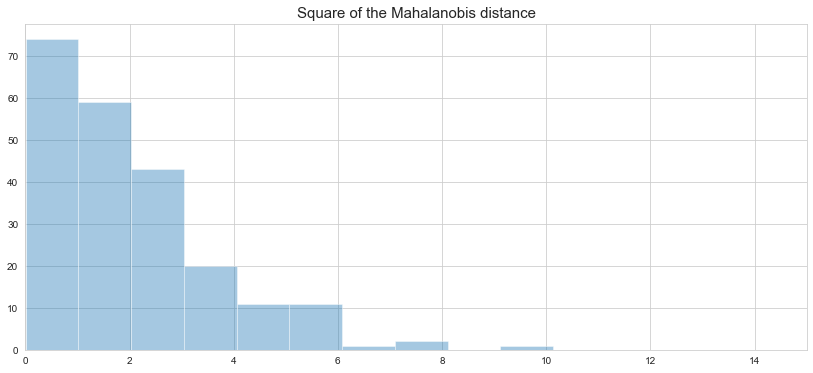

In [10]:
plt.figure(figsize=(14, 6))
sns.distplot(np.square(dist_train),
             bins=10,
             kde=False).set_title('Square of the Mahalanobis distance', fontsize=15)
plt.xlim([0.0, 15])
plt.show()

From the distribution below, we can set the anomaly threshold to be 4 standard deviations from mean of training data's Mahalanobis distances.

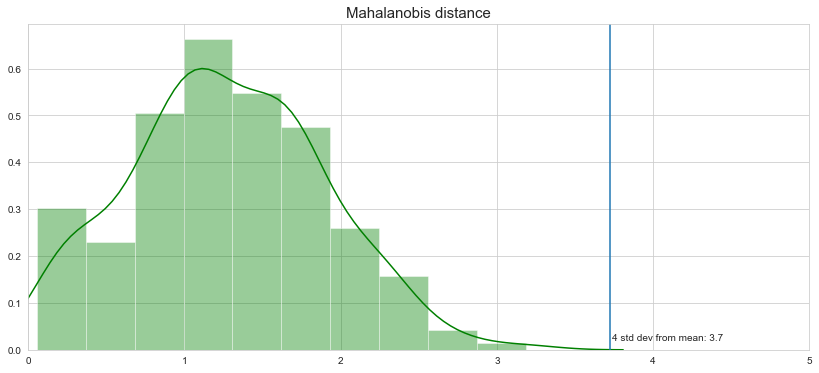

In [11]:
plt.figure(figsize=(14, 6))
sns.distplot(dist_train,
             bins=10,
             kde=True,
             color='green').set_title('Mahalanobis distance', fontsize=15)

plt.axvline(threshold)
plt.text(threshold + 0.01, 0.02, '4 std dev from mean: ' +
         str(round(threshold, 1)))

plt.xlim([0.0, 5])
plt.show()

In [12]:
# save the Mahalanobis distance, as well as the threshold value and “anomaly flag” variable for both train and test data in a dataframe

anomaly_train = pd.DataFrame()
anomaly_train['Mob dist'] = dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist'] = dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
2004-02-13 23:52:39,1.032676,3.724605,False
2004-02-14 00:02:39,1.148163,3.724605,False
2004-02-14 00:12:39,1.509998,3.724605,False
2004-02-14 00:22:39,1.849725,3.724605,False
2004-02-14 00:32:39,0.701075,3.724605,False


In [13]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

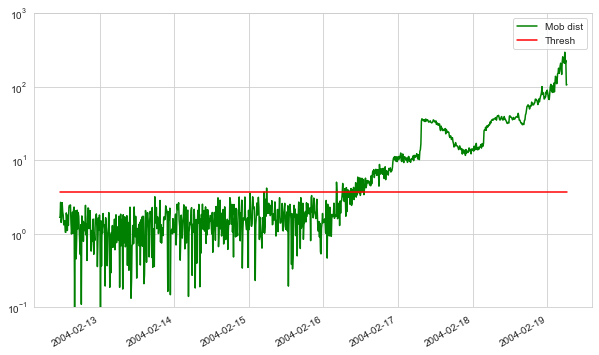

In [14]:
anomaly_alldata.plot(logy=True, figsize=(10, 6), ylim=[
                     1e-1, 1e3], color=['green', 'red'])
plt.show()

# Approach 2: Autoencoder model for anomaly detection (unsupervised)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import time
import copy
from numpy.random import seed

seed(10)
torch.manual_seed(10)

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2070


## Define model and train model

In [6]:
class autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ELU(),
            nn.Linear(10, 2),
            nn.ELU())
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.ELU(),
            nn.Linear(10, input_dim))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 300
BATCH_SIZE = 8
SHOW_PROGRESS = 50

ae_model = autoencoder(X_train.shape[1]).to(device)
optimiser = optim.Adam(ae_model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()

# train validation split
input_train, input_val, _, _ = train_test_split(
    X_train, X_train, test_size=0.2, random_state=10)

input_train = torch.from_numpy(input_train.values).float().to(device)
input_val = torch.from_numpy(input_val.values).float().to(device)

# create torch dataset
dataset_train = torch.utils.data.TensorDataset(input_train)
dataset_val = torch.utils.data.TensorDataset(input_val)
data_generator_train = torch.utils.data.DataLoader(
    dataset_train, BATCH_SIZE, shuffle=True, drop_last=True)
data_generator_val = torch.utils.data.DataLoader(
    dataset_val, BATCH_SIZE, shuffle=True, drop_last=True)

# training...

epochs = []
losses_train = []
losses_val = []
lowest_loss = 10000

checkpoint = time.time()
for epoch in range(NUM_EPOCHS):
    epochs.append(epoch+1)
    epoch_losses_train = []

    for data_train in data_generator_train:

        ae_model.train()
        optimiser.zero_grad()

        prediction = ae_model(data_train[0])
        loss = criterion(prediction, data_train[0])
        loss.backward()
        optimiser.step()
        epoch_losses_train.append(loss.item())

    epoch_losses_train = np.average(np.array(epoch_losses_train))
    losses_train.append(epoch_losses_train)

    epoch_losses_val = []

    for data_val in data_generator_val:

        ae_model.eval()
        with torch.no_grad():
            prediction = ae_model(data_val[0])
            loss = criterion(prediction, data_val[0])
            epoch_losses_val.append(loss.item())

    epoch_losses_val = np.average(np.array(epoch_losses_val))
    losses_val.append(epoch_losses_val)

    # show training progress at pre-defined interval
    if epoch % SHOW_PROGRESS == SHOW_PROGRESS-1:
        print('Epoch: {} | Train Loss: {:.4} | Val Loss: {:.4}'.format(
            epoch+1, epoch_losses_train, epoch_losses_val))

    # save best model
    if epoch_losses_val < lowest_loss:
        lowest_loss = epoch_losses_val
        best_epoch = epoch + 1
        best_model_wts = copy.deepcopy(ae_model.state_dict())

time_elapsed = time.time() - checkpoint
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

print('Lowest validation loss: {:.4} at epoch {}'.format(
    lowest_loss, best_epoch))
ae_model.load_state_dict(best_model_wts)

Epoch: 50 | Train Loss: 0.01235 | Val Loss: 0.01644
Epoch: 100 | Train Loss: 0.01048 | Val Loss: 0.01505
Epoch: 150 | Train Loss: 0.009856 | Val Loss: 0.01213
Epoch: 200 | Train Loss: 0.009571 | Val Loss: 0.01113
Epoch: 250 | Train Loss: 0.009535 | Val Loss: 0.01071
Epoch: 300 | Train Loss: 0.009295 | Val Loss: 0.01062
Training complete in 0m 29s
Lowest validation loss: 0.008314 at epoch 251


<All keys matched successfully>

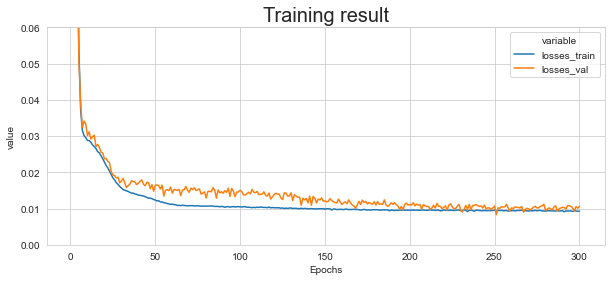

In [8]:
train_result_df = pd.DataFrame(list(zip(epochs, losses_train, losses_val)), columns=['Epochs', 'losses_train', 'losses_val'])

train_result_melt_df = pd.melt(train_result_df, id_vars=['Epochs'], value_vars=['losses_train', 'losses_val'])

# lineplot
plt.figure(figsize=(10, 4))
sns.lineplot(x='Epochs',
             y='value',
             hue='variable',
             data=train_result_melt_df
             ).set_title('Training result', fontsize=20)
plt.ylim(0, 0.06)

plt.show()

## Distribution of loss function in the training set

By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level”, and that any flagged anomalies should be statistically significant above the noise background.

From our result, we can use a threshold of 0.3 for flagging an anomaly. We can then calculate the loss in the test set, to check when the output crosses the anomaly threshold.

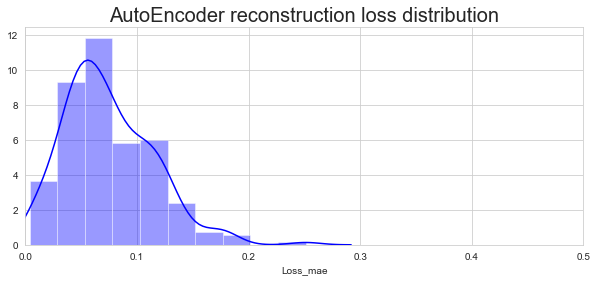

In [13]:
ae_model.eval()
with torch.no_grad():
    X_pred_train = ae_model(torch.from_numpy(X_train.values).float().to(device)).detach().cpu().numpy()

X_pred_train = pd.DataFrame(X_pred_train, columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
plt.figure(figsize=(10, 4))
sns.distplot(scored_train['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue').set_title('AutoEncoder reconstruction loss distribution', fontsize=20)
plt.xlim([0.0,.5])
plt.show()

In [10]:
THRESHOLD = 0.3

ae_model.eval()
with torch.no_grad():
    X_pred_test = ae_model(torch.from_numpy(X_test.values).float().to(device)).detach().cpu().numpy()
    
X_pred_test = pd.DataFrame(X_pred_test, columns=X_test.columns)
X_pred_test.index = X_test.index

scored_test = pd.DataFrame(index=X_test.index)
scored_test['Loss_mae'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)
scored_test['Threshold'] = THRESHOLD
scored_test['Anomaly'] = scored_test['Loss_mae'] > scored_test['Threshold']
display(scored_test.head())

scored_train['Threshold'] = THRESHOLD
scored_train['Threshold'] = THRESHOLD
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored_test])

,Loss_mae,Threshold,Anomaly
2004-02-13 23:52:39,0.128251,0.3,False
2004-02-14 00:02:39,0.089362,0.3,False
2004-02-14 00:12:39,0.026083,0.3,False
2004-02-14 00:22:39,0.079657,0.3,False
2004-02-14 00:32:39,0.111359,0.3,False


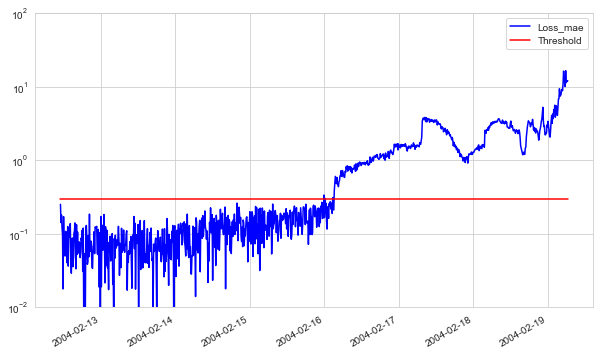

In [14]:
# plot AutoEncoder reconstruction loss over time

scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])
plt.show()